Create auxilary functions for data generation.

In [1]:
import PolynomialRoots.roots
using Distributions
using Plots

function generate_coefficients(order::Int)
    stable = false
    true_a = []
    # Keep generating coefficients until we come across a set of coefficients
    # that correspond to stable poles
    while !stable
        true_a = randn(order)
        coefs =  append!([1.0], -true_a)
        if false in ([abs(root) for root in roots(coefs)] .> 1)
            continue
        else
            stable = true
        end
    end
    return true_a
end

function generateAR(num::Int, order::Int; nvar=1, stat=true, coefs=nothing)
    if isnothing(coefs) && stat
        coefs = generate_coefficients(order)
    else
        coefs = randn(order)
    end
    inits = randn(order)
    data = Vector{Vector{Float64}}(undef, num+3*order)
    data[1] = inits
    for i in 2:num+3*order
        data[i] = insert!(data[i-1][1:end-1], 1, rand(Distributions.Normal(coefs'data[i-1], sqrt(nvar[])), 1)[1])
    end
    data = data[1+3*order:end]
    return coefs, data
end

generateAR (generic function with 1 method)

In [2]:
using Random
Random.seed!(42)

n_datasets = 100
n_samples = 100
AR_z = 4:8
AR_x = 1:4
noise_var = [1.0, 0.3, 0.1]
SNR_s = rand(noise_var, n_datasets)
speech_data, noise_data = [generateAR(100, rand(AR_z)) for _ in 1:n_datasets], [generateAR(100, rand(AR_x), nvar=SNR_s[i]) for i in 1:n_datasets];

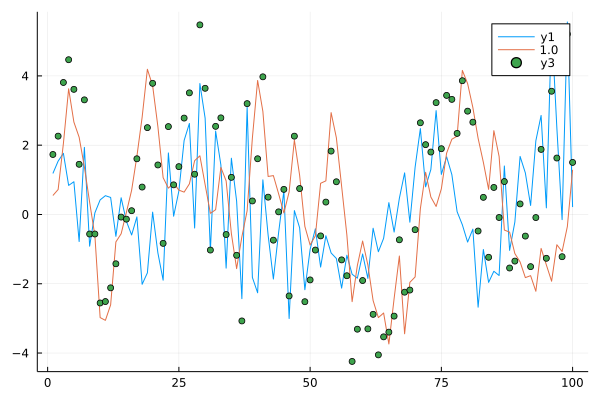

In [4]:
index = 10
plot(first.(speech_data[index][2]))
plot!(first.(noise_data[index][2]), label=SNR_s[20])
output = first.(speech_data[index][2]) + first.(noise_data[index][2])
scatter!(output)

In [2]:
using AIDA
using ReactiveMP
import ProgressMeter

┌ Info: Precompiling AIDA [02ab3c64-7f6e-4624-92b1-4056b28faae1]
└ @ Base loading.jl:1317


### Coupled AR inference

In [9]:
vmp_its = 100

rmx = zeros(n_datasets, n_samples)
rvx = zeros(n_datasets, n_samples)
rmθ, rvθ = [], []
rγ = fill(tuple(.0, .0), n_datasets)

rmz = zeros(n_datasets, n_samples)
rvz = zeros(n_datasets, n_samples)
rmη, rvη  = [], []
rτ = fill(tuple(.0, .0), n_datasets)

fe  = zeros(n_datasets, vmp_its)

ProgressMeter.@showprogress for i in 1:n_datasets
    
    output = first.(speech_data[i][2]) + first.(noise_data[i][2])
    ar_speech, ar_env = length(speech_data[i][1]), length(noise_data[i][1])
    
    priors_mη, priors_vη, priors_τ = prior_to_priors(zeros(ar_env), diageye(ar_env), (1.0, SNR_s[i]), n_samples, ar_env)
    
    prior_η                           = (priors_mη[i, :], priors_vη[i, :, :])
    prior_τ                           = priors_τ[i]
    γ, θ, zs, τ, η, xs, fe[i, :]      = coupled_inference(output, prior_η, prior_τ, ar_speech, ar_env, vmp_its)
    mz, vz                            = mean.(zs), cov.(zs)
    mθ, vθ                            = mean(θ), cov(θ)
    rmz[i, :], rvz[i, :]              = first.(mz), first.(vz)
    
    push!(rmθ, mθ)
    push!(rvθ, vθ)
    
    rγ[i]                             = shape(γ), rate(γ)
    
    mx, vx                            = mean.(xs), cov.(xs)
    mη, vη                            = mean(η), cov(η)
    rmx[i, :], rvx[i, :]              = first.(mx), first.(vx)
    push!(rmη, mη)
    push!(rvη, vη)
    rτ[i]                             = shape(τ), rate(τ)

end

Progress:   2%|▉                                        |  ETA: 0:04:07

Progress:   3%|█▎                                       |  ETA: 0:04:15

Progress:   4%|█▋                                       |  ETA: 0:04:40

Progress:   5%|██                                       |  ETA: 0:04:52

Progress:   6%|██▌                                      |  ETA: 0:04:59

Progress:   7%|██▉                                      |  ETA: 0:05:05

Progress:   8%|███▎                                     |  ETA: 0:04:58

Progress:   9%|███▊                                     |  ETA: 0:04:59

Progress:  10%|████▏                                    |  ETA: 0:05:01

Progress:  11%|████▌                                    |  ETA: 0:05:01

Progress:  12%|████▉                                    |  ETA: 0:05:05

Progress:  13%|█████▍                                   |  ETA: 0:05:00

Progress:  14%|█████▊                                   |  ETA: 0:04:56

Progress:  15%|██████▏                                  |  ETA: 0:04:54

Progress:  16%|██████▌                                  |  ETA: 0:04:54

Progress:  17%|███████                                  |  ETA: 0:04:54

Progress:  18%|███████▍                                 |  ETA: 0:04:53

Progress:  19%|███████▊                                 |  ETA: 0:04:47

Progress:  20%|████████▎                                |  ETA: 0:04:44

Progress:  21%|████████▋                                |  ETA: 0:04:43

Progress:  22%|█████████                                |  ETA: 0:04:37

Progress:  23%|█████████▍                               |  ETA: 0:04:36

Progress:  24%|█████████▉                               |  ETA: 0:04:35

Progress:  25%|██████████▎                              |  ETA: 0:04:30

Progress:  26%|██████████▋                              |  ETA: 0:04:27

Progress:  27%|███████████▏                             |  ETA: 0:04:24

Progress:  28%|███████████▌                             |  ETA: 0:04:20

Progress:  29%|███████████▉                             |  ETA: 0:04:22

Progress:  30%|████████████▎                            |  ETA: 0:04:22

Progress:  31%|████████████▊                            |  ETA: 0:04:20

Progress:  32%|█████████████▏                           |  ETA: 0:04:18

Progress:  33%|█████████████▌                           |  ETA: 0:04:15

Progress:  34%|██████████████                           |  ETA: 0:04:09

Progress:  35%|██████████████▍                          |  ETA: 0:04:04

Progress:  36%|██████████████▊                          |  ETA: 0:04:00

Progress:  37%|███████████████▏                         |  ETA: 0:03:54

Progress:  38%|███████████████▋                         |  ETA: 0:03:50

Progress:  39%|████████████████                         |  ETA: 0:03:47

Progress:  40%|████████████████▍                        |  ETA: 0:03:44

Progress:  41%|████████████████▊                        |  ETA: 0:03:39

Progress:  42%|█████████████████▎                       |  ETA: 0:03:35

Progress:  43%|█████████████████▋                       |  ETA: 0:03:30

Progress:  44%|██████████████████                       |  ETA: 0:03:26

Progress:  45%|██████████████████▌                      |  ETA: 0:03:22

Progress:  46%|██████████████████▉                      |  ETA: 0:03:20

Progress:  47%|███████████████████▎                     |  ETA: 0:03:16

Progress:  48%|███████████████████▋                     |  ETA: 0:03:11

Progress:  49%|████████████████████▏                    |  ETA: 0:03:07

Progress:  50%|████████████████████▌                    |  ETA: 0:03:04

Progress:  51%|████████████████████▉                    |  ETA: 0:03:01

Progress:  52%|█████████████████████▍                   |  ETA: 0:02:57

Progress:  53%|█████████████████████▊                   |  ETA: 0:02:53

Progress:  54%|██████████████████████▏                  |  ETA: 0:02:51

Progress:  55%|██████████████████████▌                  |  ETA: 0:02:48

Progress:  56%|███████████████████████                  |  ETA: 0:02:44

Progress:  57%|███████████████████████▍                 |  ETA: 0:02:40

Progress:  58%|███████████████████████▊                 |  ETA: 0:02:36

Progress:  59%|████████████████████████▎                |  ETA: 0:02:33

Progress:  60%|████████████████████████▋                |  ETA: 0:02:29

Progress:  61%|█████████████████████████                |  ETA: 0:02:25

Progress:  62%|█████████████████████████▍               |  ETA: 0:02:22

Progress:  63%|█████████████████████████▉               |  ETA: 0:02:18

Progress:  64%|██████████████████████████▎              |  ETA: 0:02:14

Progress:  65%|██████████████████████████▋              |  ETA: 0:02:10

Progress:  66%|███████████████████████████              |  ETA: 0:02:07

Progress:  67%|███████████████████████████▌             |  ETA: 0:02:03

Progress:  68%|███████████████████████████▉             |  ETA: 0:02:00

Progress:  69%|████████████████████████████▎            |  ETA: 0:01:57

Progress:  70%|████████████████████████████▊            |  ETA: 0:01:54

Progress:  71%|█████████████████████████████▏           |  ETA: 0:01:50

Progress:  72%|█████████████████████████████▌           |  ETA: 0:01:46

Progress:  73%|█████████████████████████████▉           |  ETA: 0:01:42

Progress:  74%|██████████████████████████████▍          |  ETA: 0:01:38

Progress:  75%|██████████████████████████████▊          |  ETA: 0:01:34

Progress:  76%|███████████████████████████████▏         |  ETA: 0:01:31

Progress:  77%|███████████████████████████████▋         |  ETA: 0:01:27

Progress:  78%|████████████████████████████████         |  ETA: 0:01:23

Progress:  79%|████████████████████████████████▍        |  ETA: 0:01:19

Progress:  80%|████████████████████████████████▊        |  ETA: 0:01:15

Progress:  81%|█████████████████████████████████▎       |  ETA: 0:01:12

Progress:  82%|█████████████████████████████████▋       |  ETA: 0:01:08

Progress:  83%|██████████████████████████████████       |  ETA: 0:01:04

Progress:  84%|██████████████████████████████████▌      |  ETA: 0:01:00

Progress:  85%|██████████████████████████████████▉      |  ETA: 0:00:56

Progress:  86%|███████████████████████████████████▎     |  ETA: 0:00:52

Progress:  87%|███████████████████████████████████▋     |  ETA: 0:00:48

Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:44

Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:40

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:37

Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:33

Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:29

Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:26

Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:22

Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:18

Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:15

Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:00:11

Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:07

Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:04

Progress: 100%|█████████████████████████████████████████| Time: 0:06:11


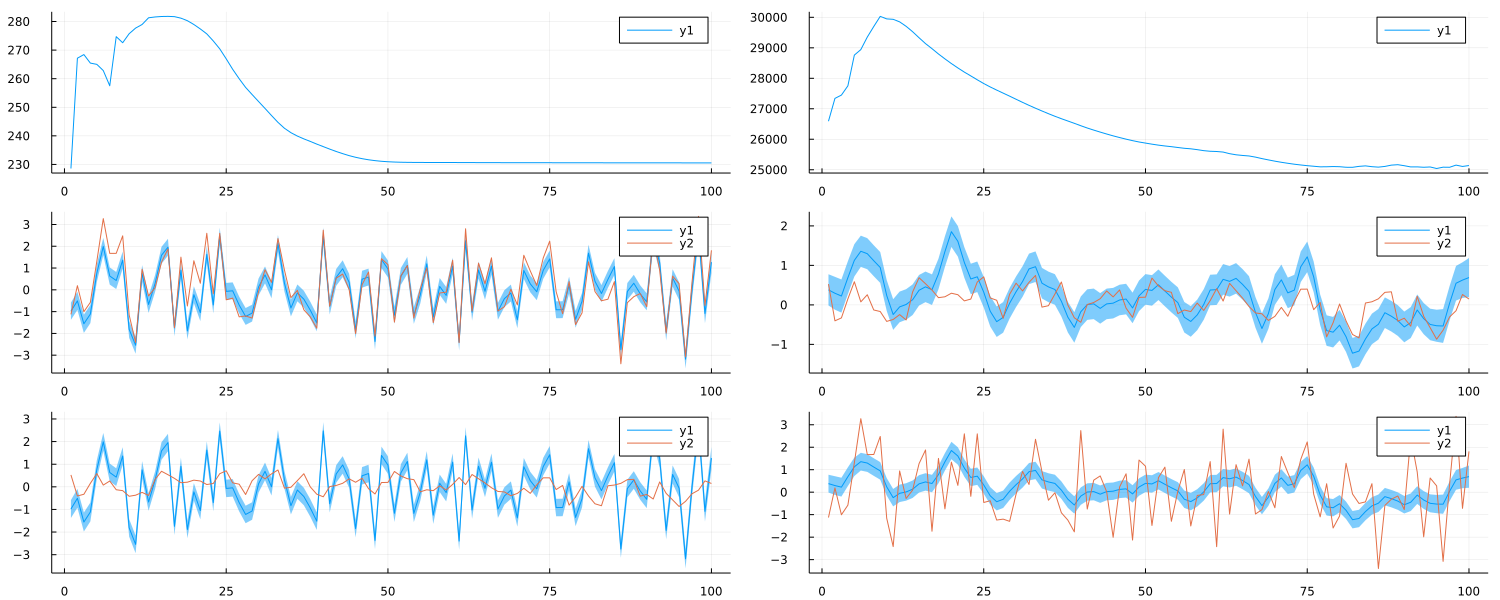

In [25]:
index = 11

p00 = plot(fe[index, :])
p01 = plot(sum(fe, dims=1)')

p1 = plot(rmz[index, :], ribbon=sqrt.(rvz[index, :]))
p1 = plot!(p1, first.(speech_data[index][2]))

p2 = plot(rmx[index, :], ribbon=sqrt.(rvx[index, :]))
p2 = plot!(p2, first.(noise_data[index][2]))

p3 = plot(rmz[index, :], ribbon=sqrt.(rvz[index, :]))
p3 = plot!(p3, first.(noise_data[index][2]))

p4 = plot(rmx[index, :], ribbon=sqrt.(rvx[index, :]))
p4 = plot!(p4, first.(speech_data[index][2]))

plot(p00, p01, p1, p2, p3, p4, layout = @layout([ a b; c d; e f  ]), size = (1500, 600))

### FE for context inference

In [605]:
using Random
Random.seed!(0)

n_datasets = 1000
n_samples = 100
AR_z = 1:4
AR_x = 1:4
variances = [2.0, 1.0, 0.5, 0.3, 0.1]
var_z = rand(variances, n_datasets)
var_x = rand(variances, n_datasets)
data = [[generateAR(n_samples, rand(AR_z),  nvar=var_z[i]) for i in 1:n_datasets], [generateAR(n_samples, rand(AR_x), nvar=var_x[i]) for i in 1:n_datasets]];

In [606]:
# compute free energies of two models (gaussian for silent frame, lar for voiced frame)
active_models = []
active_scenes = []
vmp_iter = 50
ProgressMeter.@showprogress for j in 1:n_datasets
    push!(active_scenes, rand(1:length(data)))
    coefs_1, coefs_2 = data[1][j][1], data[2][j][1]
    observations = first.(data[active_scenes[end]][j][2])
    scene = model_selection(observations, 
                            [lar_inference, lar_inference, lar_inference],
                            [
                                Dict(:mθ => coefs_1, :vθ => diageye(length(coefs_1)), :aτ => 1e12, :bτ => 1.0, :aγ => 1.0, :bγ => var_z[j], :order => length(coefs_1)), 
                                Dict(:mθ => coefs_2, :vθ => diageye(length(coefs_2)), :aτ => 1e12, :bτ => 1.0, :aγ => 1.0, :bγ => var_x[j], :order => length(coefs_2)),
                                Dict(:mθ => zeros(1), :vθ => diageye(1), :aτ => 1e12, :bτ => 1.0, :aγ => 1.0, :bγ => 1.0, :order => 1),
                            ],
                             vmp_iter=vmp_iter)
    push!(active_models, scene)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:31:38


In [616]:
println("Correct: $(n_datasets - mean((active_models .- active_scenes).^2) * n_datasets)")

Correct: 773.0


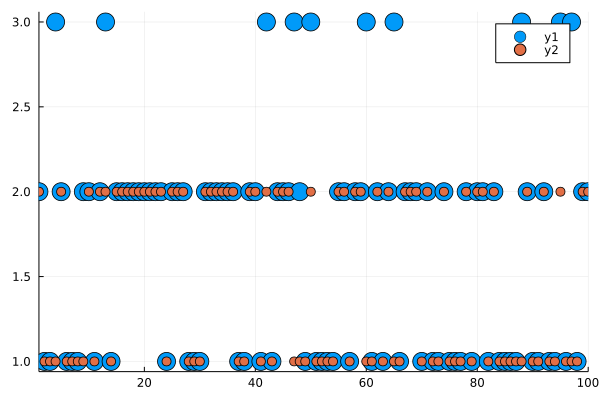

In [611]:
scatter(active_models,markersize=10.0)
scatter!(active_scenes, xlims=(1, 100), markersize=5.0)

### Flow model (preference learning)

In [4]:
function generate_data(nr_samples::Int64)

    # sample weights
    w = rand(nr_samples,2)

    # sample appraisal
    y = zeros(Float64, nr_samples)
    for k = 1:nr_samples
        y[k] = 1.0*(w[k,1] > 0.5)*(w[k,2] < 0.5)
    end

    # return data
    return y, w

end;

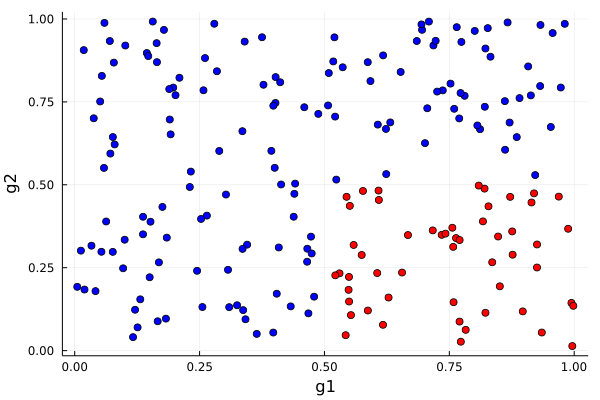

In [5]:
dat_to_col(data) = map(x -> x == 1 ? "red" : "blue", Int64.(round.(data)))
data_y, data_x = generate_data(200);
scatter(data_x[:,1], data_x[:,2], color=dat_to_col(data_y), grid=true, xlabel="g1", ylabel="g2", label=false)

In [13]:
function f(params)
    fe = inference_flow_classifier(Float64.(data_y), [data_x[k,:] for k=1:size(data_x,1)], params)
    return fe
end;

In [14]:
using Optim
res_train = optimize(f, randn(12), LBFGS(), Optim.Options(store_trace = true, show_trace = true, f_tol=1e-6), autodiff=:forward);

Iter     Function value   Gradient norm 
     0     5.570006e+03     5.947638e+03
 * time: 0.00014019012451171875
     1     2.409632e+03     2.138678e+03
 * time: 0.23980116844177246
     2     4.257963e+02     4.050597e+02
 * time: 0.36351704597473145
     3     2.956810e+02     2.149836e+02
 * time: 0.48039913177490234
     4     1.519398e+02     1.686794e+02
 * time: 0.6347529888153076
     5     1.489554e+02     1.958977e+02
 * time: 0.7903850078582764
     6     1.178459e+02     1.280385e+02
 * time: 0.9482591152191162
     7     1.039498e+02     4.360670e+02
 * time: 1.1029930114746094
     8     1.004968e+02     1.885277e+02
 * time: 1.220757007598877
     9     9.831465e+01     8.439614e+01
 * time: 1.3766260147094727
    10     9.306979e+01     2.945863e+02
 * time: 1.6148979663848877
    11     9.053944e+01     1.849190e+02
 * time: 1.9602279663085938
    12     8.986872e+01     3.724525e+02
 * time: 4.752624988555908
    13     8.681244e+01     3.434536e+02
 * time: 4.90967

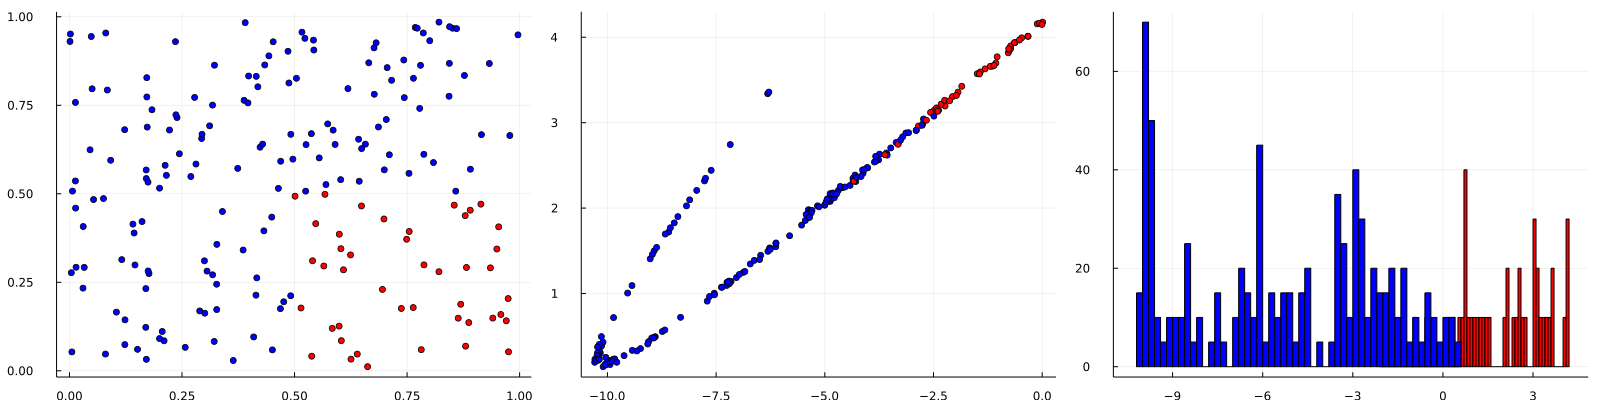

In [33]:
using ImageCore
using LinearAlgebra

est_params = Optim.minimizer(res_train)
cmap = colorsigned(color("blue"), color("magenta"), color("red")) ∘ scalesigned(0, 0.5, 1.0)
colors = cmap.(data_y)
inferred_model = deepcopy(compile(model, est_params))
trans_data_x_1 = hcat(map((x) -> forward(inferred_model, x), [data_x[k,:] for k=1:size(data_x,1)])...)'
trans_data_x_2 = map((x) -> dot([1, 1], x), [trans_data_x_1[k,:] for k=1:size(data_x,1)])
trans_data_x_2_split = [trans_data_x_2[data_y .>= 0.5], trans_data_x_2[data_y .<= 0.5]]
plt1 = scatter(data_x[:,1], data_x[:,2], color=colors)
plt2 = scatter(trans_data_x_1[:,1], trans_data_x_1[:,2], color=colors)
hist = histogram(trans_data_x_2_split; stacked=true, normalize=:density, bins=60,  fillcolor=["red" "blue"], label = ["Positive" "Negative"], legend=:topleft)
plot(plt1, plt2, hist, size=(1600, 400), legend=false, layout=(1, 3))

Flow model planning

In [8]:
# test
function f_input(input)
    fe = inference_flow_classifier_input(input, model, est_params)
    return fe
end;

In [11]:
est_params = Optim.minimizer(res_train)

12-element Vector{Float64}:
 -2.030353376256365
 -0.13831788724320088
  0.7498859607822699
 -1.8737753242781956
  3.2605653417844205
  2.2940361888592955
  3.848406805159754
 -5.322444753976864
 -3.390173423215836
 -4.129621861652888
  0.6426772917063536
 -0.1437627384228967

In [12]:
res = optimize(f_input, rand(2), LBFGS(), Optim.Options(iterations = 100, store_trace = true, show_trace = true), autodiff=:forward)

LoadError: MethodError: no method matching compile(::FlowModel{8, Tuple{ReactiveMP.AdditiveCouplingLayerEmpty{Tuple{ReactiveMP.PlanarFlowEmpty{1}}}, PermutationLayer{Int64}, ReactiveMP.AdditiveCouplingLayerEmpty{Tuple{ReactiveMP.PlanarFlowEmpty{1}}}, PermutationLayer{Int64}, ReactiveMP.AdditiveCouplingLayerEmpty{Tuple{ReactiveMP.PlanarFlowEmpty{1}}}, PermutationLayer{Int64}, ReactiveMP.AdditiveCouplingLayerEmpty{Tuple{ReactiveMP.PlanarFlowEmpty{1}}}, PermutationLayer{Int64}}}, ::typeof(params))
[0mClosest candidates are:
[0m  compile(::FlowModel) at /Users/apodusenko/.julia/packages/ReactiveMP/7BLWW/src/nodes/flow/flow_models/flow_model.jl:63
[0m  compile(::FlowModel, [91m::Vector{T} where T[39m) at /Users/apodusenko/.julia/packages/ReactiveMP/7BLWW/src/nodes/flow/flow_models/flow_model.jl:78
[0m  compile([91m::ReactiveMP.AdditiveCouplingLayerEmpty[39m, ::Any) at /Users/apodusenko/.julia/packages/ReactiveMP/7BLWW/src/nodes/flow/layers/additive_coupling_layer.jl:84
[0m  ...

In [ ]:
z = zeros(100,100)
for kx = 1:100
    for ky = 1:100
        z[kx, ky] = generate_user_response([kx/100, ky/100])
    end
end